In [ ]:
!git clone https://github.com/maichi98/PythonM2-jour4.git
%cd PythonM2-jour4/

Cloning into 'PythonM2-jour4'...
remote: Enumerating objects: 59114, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 59114 (delta 10), reused 18 (delta 7), pack-reused 59090 (from 1)
Receiving objects: 100% (59114/59114), 962.84 MiB | 22.92 MiB/s, done.
Resolving deltas: 100% (65/65), done.
Updating files: 100% (94477/94477), done.
/content/PythonM2-jour4


<h1 style="font-size:50px; text-align:center; padding:15px;">
    Deep Learning Tutorial - Segmentation of Brain MR Images
</h1>


In this tutorial, we will explore how **deep learning models**, particularly the **U-Net architecture**, can be applied to **automatically** segment brain tumors, from MR images.

Over the last decade, deep learning has revolutionized numerous fields, including **medical imaging**. These Deep learning solutions are increasingly being integrated into patient care, allieviating the workload of medical professionals and enhancing diagnostic accuracy.

One standout application is **automatic segmentation** which has become mainstream in medical diagnostics and treatment planning. **Manual contouring** is not only **time consuming** but also **highly subjective**, leading to **inter-observer variability**—differences in segmentation results between radiologists.

An objective delianation of the tumor by use of a AI model with soTA performance makes the longitudinal assessment of **tumor progression** and its **response to treatment** much more **robust**.


<h1 style="font-size:25px; padding:5px;">
   But What is segmentation ?
</h1>

Segmentation is a key task in medical image analysis, where an image is divided into meaningful regions, typically to identify structures like **organs**, or **tumors**. In **brain tumor segmentation**, the goal is to separate the tumor from healthy brain tissue in MRI scans.

Unlike **classification** (which labels an entire image), or **detection** (which identifies object locations), segmentation provides a **pixel-wise mask**, which is crucial for treatment planning, and disease monitoring.

<div style="text-align: center;">
    <img src="https://raw.githubusercontent.com/maichi98/PythonM2-jour4/main/resources/classification%20vs%20detection%20vs%20segmentation.jpeg" alt="Classification vs Detection vs Segmentation" width="1000px">
</div>


In image segmentation, a deep learning model learns to classify each pixel in an image as belonging to a specific category :

<div style="text-align: center;">
    <img src="https://raw.githubusercontent.com/maichi98/PythonM2-jour4/main/resources/segmentation.png" alt="Classification vs Detection vs Segmentation" width="1000px">
</div>

<h1 style="font-size:25px; padding:5px;">
The BraTS Challenge: Brain Tumor Segmentation Benchmark 🧠🎯
</h1>

The **Brain Tumor Segmentation (BraTS) Challenge** is an international competition designed to advance the development of **automated brain tumor segmentation models**. It provides researchers with standardized datasets and evaluation metrics to compare different deep-learning approaches.

the labels L1, L2, and L4 refer to different types of tumor structures annotated in the MRI scans. Specifically:

- **L1 (NCR/NET - Necrotic and Non-Enhancing Tumor Core)** : Represents the necrotic (dead) tumor core and the non-enhancing tumor regions.

- **L2 (ED - Peritumoral Edema)** : Represents peritumoral edema, which is swelling around the tumor due to fluid accumulation.
It often surrounds the tumor and appears as hyperintense regions in FLAIR sequences.
- **L4 (ET - Enhancing Tumor)** : Represents the enhancing tumor region, which is the actively growing part of the tumor.
It appears as a bright region in contrast-enhanced MRI (T1ce) scans.


<div style="text-align: center;">
    <img src="https://raw.githubusercontent.com/maichi98/PythonM2-jour4/main/resources/BRats.png" alt="two different subjects from the BraTS dataset" width="1000px">
</div>

## 🧠 Exercise 0: Visualizing a BraTS Patient's MRI Scans

- Load **multi-modal MRI scans** (T1, T1gd, T2, FLAIR) from a BraTS patient in the folder (example BraTS patients).
- Extract an **axial-slice** (middle cross section).
- Visualize different **MRI sequences side by side** along with the slice's corresponding mask

In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Specify the name of the patient whose data we want to visualize :
patient_name = "BraTS19_CBICA_AAG_1"

# Create a dictionary to store the paths to the MRI scans for different imaging modalities
# The keys are the modality names (t1, t1ce, t2, flair), and the values are the corresponding file paths
dict_mri_paths = {
    imaging: fr"example BraTS patients/{patient_name}/{patient_name}_{imaging}.nii.gz"
    for imaging in .............  # Your code here
}

# Path to the segmentation mask file for the patient
path_seg = fr"example BraTS patients/{patient_name}/{patient_name}_seg.nii.gz"

# Load the MRI images for each modality using nibabel
# The images are stored as NumPy arrays in a dictionary, with modality names as keys
dict_mri_images = {
    imaging: nib.load(dict_mri_paths[imaging]).get_fdata()
    for imaging in ["t1", "t1ce", "t2", "flair"]
}

# Load the segmentation mask using nibabel
# The mask is stored as a NumPy array
img_seg =  .............  # Your code here

# Select the slice index to visualize, for example 55
slice_idx = 55


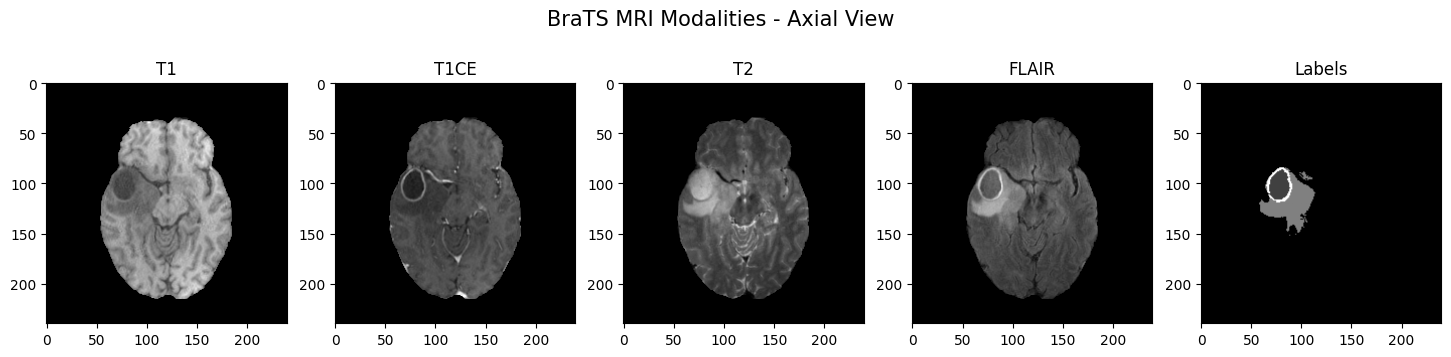

In [ ]:
# Plot the MRI slices and the Labels data :
fig, axes = plt.subplots(1, 5, figsize=(18, 4))

for i, imaging in enumerate(["t1", "t1ce", "t2", "flair"]):

    axes[i].imshow(dict_mri_images[imaging][:, :, slice_idx].T, cmap="gray")
    axes[i].set_title(imaging.upper())

axes[4].imshow(img_seg[:, :, slice_idx].T, cmap="gray")
axes[4].set_title("Labels")

plt.suptitle("BraTS MRI Modalities - Axial View", fontsize=15)
plt.show()


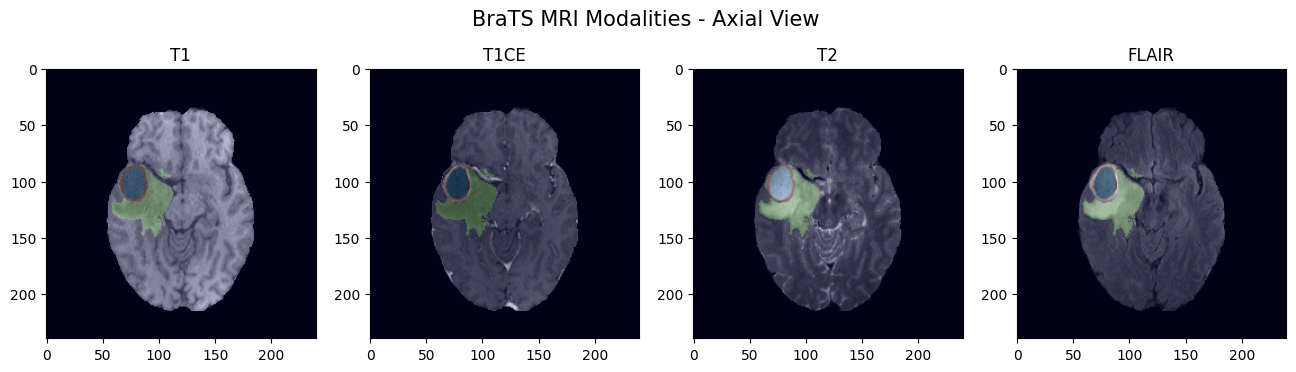

In [ ]:
# Plot the MRI slices with the Labels overlayed on the mri image :
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for i, imaging in enumerate(["t1", "t1ce", "t2", "flair"]):

    axes[i].imshow(dict_mri_images[imaging][:, :, slice_idx].T, cmap="gray")
    axes[i].imshow(img_seg[:, :, slice_idx].T, cmap="jet", alpha=0.2)
    axes[i].set_title(imaging.upper())

plt.suptitle("BraTS MRI Modalities - Axial View", fontsize=15)
plt.show()


In this tutorial, we'll simplify the BraTS challenge, as we will attempt to predict the **L4 (ET - Enhancing Tumor)** based on the T1CE imaging, using the U-Net architecture :

<h1 style="font-size:15px; padding:5px;">
   Dataset Details
</h1>

The dataset used in this tutorial consists of T1CE MRI brain scans from 335 patients.

- Each patient has multiple **2D slices** extracted from their **3D T1CE MRI scan**.

- The naming convention (patient_XXX_YYYY.nii.gz) indicates:
    - **XXX** → Patient ID
    - **YYYY** → Slice number within that patient’s scan.



The dataset is organized into two main folders :

- **Train** - Contains images and corresponding segmentation masks from **284** patients, for training the deep learning model.
- **Test**  - Contains images and segmentation masks from **51** patients, for evaluating the model after training

Each subset is further divided into:

- Images: Contains 2D slices of the brain MRI scans.
  
- Masks: Contains the corresponding binary segmentation masks, where:
    - 1 (White) represents the enhancing tumor region .
    - 0 (Black) represents all tissue that is not enhancing tumor .
    
    
    ├── train
    │   ├── images
    │   │   ├── patient_001_0001.nii.gz
    │   │   ├── patient_001_0002.nii.gz
    │   │   ├── ...
    │   ├── masks
    │   │   ├── patient_001_0001.nii.gz
    │   │   ├── patient_001_0002.nii.gz
    │   │   ├── ...
    ├── test
    │   ├── images
    │   │   ├── patient_251_0001.nii.gz
    │   │   ├── patient_251_0002.nii.gz
    │   │   ├── ...
    │   ├── masks
    │   │   ├── patient_251_0001.nii.gz
    │   │   ├── patient_251_0002.nii.gz
    │   │   ├── ...
    

<h1 style="font-size:15px; padding:5px;">
   U-Net Architecture
</h1>

U-Net is a fully convolutional neural network (FCN) designed for image segmentation, **widely used in medical imaging**. It follows an encoder-bottleneck-decoder structure :

- **Encoder (Contracting Path)**: Uses convolution and pooling layers to extract high-level features.

- **Decoder (Expanding Path)**: Upsamples features and combines them with encoder outputs via skip connections to restore spatial details.

- **Skip Connections:** Help retain fine details by directly passing features from encoder to decoder.


<div style="text-align: center;">
    <img src="https://raw.githubusercontent.com/maichi98/PythonM2-jour4/main/resources/net.png" alt="U-Net model structure" width="800px">
</div>

By the end of this tutorial, you will:

- Learn about the U-Net architecture
- Implement a U-Net architecture in python using PyTorch
- Train and evaluate the segmentation performance using relevant metrics

## 🧠 Exercise 1: Split the train dataset into training images and validation images :

When training a deep learning model, our goal is to create a model that performs well not just on the training data, but also on unseen data (test set).

If we only evaluate performance on the training set, we risk **overfitting**, where the model memorizes the training data instead of learning meaningful patterns.

To ensure our deep learning model generalizes well to new, unseen data, we need to split our training dataset into two subsets:

- **Training Set**  – Used to train the model.
- **Validation Set**  – Used to evaluate model performance during **training** .

We will implement a **Patient-based Splitting** to ensure that all slices from a single patient belong **only to either training or validation**, not both :


In [ ]:
from sklearn.model_selection import train_test_split
import random
import os


# Get a list of all slice filenames in the training and test directories :
list_original_train_slices = os.listdir(.............)  # Your code here
list_test_slices = os.listdir(.............)  # Your code here

# Extract unique patient IDs from the training slice filenames :
# We use a set to ensure uniqueness and then convert it back to a list
list_original_train_ids = list(set(
    [slice_name.split("_")[1] for slice_name in list_original_train_slices]
))

# Split the training patient IDs into training and validation sets
# We use an 80/20 split (80% for training, 20% for validation)
# random_state=42 ensures that the split is always the same for reproducibility
list_train_ids, list_val_ids = train_test_split(
    .............,  # Your code here
    test_size=.............,
    random_state=.............
    )

# Create lists of training and validation slice filenames based on the split patient IDs
# We filter the original list of training slices to include only those belonging to the selected patient IDs
list_train_slices = [slice_name for slice_name
                     in list_original_train_slices
                     if slice_name.split("_")[1] in .............] # Your code here

list_val_slices = [slice_name for slice_name
                   in list_original_train_slices
                   if slice_name.split("_")[1] in .............] # Your code here

# Print the number of slices in each set
print(fr"Number of slices in the training set : {len(list_train_slices)}")
print(fr"Number of slices in the validation set : {len(list_val_slices)}")
print(fr"Number of slices in the testing set : {len(list_test_slices)}")


Number of slices in the training set : 31985
Number of slices in the validation set : 8018
Number of slices in the testing set : 7225


## 🧠 Exercise 2: Build the U-Net model :

In this exercise, we will implement the 2D U-Net model using **PyTorch**, a popular deep learning framework.

Use this diagram of the architecture of our U-Net to build the blocks of the U-Net  :

<div style="text-align: center;">
    <img src="https://raw.githubusercontent.com/maichi98/PythonM2-jour4/main/resources/unet.png" alt="U-Net model structure" width="1000px">
</div>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        """
        Initialize the U-Net model.

        Args:
            in_channels (int, optional): Number of input channels (default: 1 for grayscale images).
            out_channels (int, optional): Number of output channels (default: 1 for binary segmentation).
        """
        super(UNet, self).__init__()

        # --------------------------
        # Encoder (Contracting Path)
        # --------------------------
        # Series of convolutional blocks to extract features and downsample the input
        self.enc1 = self.conv_block(..., ...)  # Input channels to 32 feature maps
        self.enc2 = self.conv_block(..., ...)  # 32 feature maps to 64 feature maps
        self.enc3 = self.conv_block(..., ...)  # 64 feature maps to 128 feature maps
        self.enc4 = self.conv_block(..., ...)  # 128 feature maps to 256 feature maps
        self.enc5 = self.conv_block(..., ...)  # 256 feature maps to 320 feature maps


        # --------------------------
        # Bottleneck
        # --------------------------
        # Bridge between the encoder and decoder, with 320 feature maps
        self.bottleneck = self.conv_block(..., ...)

        # --------------------------
        # Decoder (Expanding Path)
        # --------------------------
        # Series of Transpose Convolution blocks to restore spatial details
        # and combine features from the encoder through skip connections
        self.up1 = nn.ConvTranspose2d(..., ..., kernel_size=2, stride=2)  # Upsample from 320 to 256 feature maps
        self.dec1 = self.conv_block(..., ...)  # Concatenate features (256 + 256 = 512) and process with conv_block

        self.up2 = nn.ConvTranspose2d(..., ..., kernel_size=2, stride=2)  # Upsample from 256 to 128 feature maps
        self.dec2 = self.conv_block(..., ...)  # Concatenate features (128 + 128 = 256) and process with conv_block

        self.up3 = nn.ConvTranspose2d(..., ..., kernel_size=2, stride=2)  # Upsample from 128 to 64 feature maps
        self.dec3 = self.conv_block(..., ...)  # Concatenate features (64 + 64 = 128) and process with conv_block

        self.up4 = nn.ConvTranspose2d(..., ..., kernel_size=2, stride=2)  # Upsample from 64 to 32 feature maps
        self.dec4 = self.conv_block(..., ...)  # Concatenate features (32 + 32 = 64) and process with conv_block

        # --------------------------
        # Output Layer
        # --------------------------
        # Final convolutional layer to produce the segmentation output
        self.out = nn.Conv2d(..., out_channels, kernel_size=1)  # 32 feature maps to the desired output channels

        # --------------------------
        # MaxPooling Layer
        # --------------------------
        # Used for downsampling in the encoder path
        self.maxpool = nn.MaxPool2d(kernel_size=..., stride=2)  # 2x2 max pooling with stride 2


    def forward(self, x):
        """
        Define the forward pass of the U-Net model.

        Args:
            x (torch.Tensor): Input tensor (image).

        Returns:
            torch.Tensor: Output tensor (segmentation mask).
        """
        # --------------------------
        # Encoding Path
        # --------------------------
        # Pass the input through the encoder blocks, applying max pooling for downsampling
        x1 = self.enc1(...)  # First encoder block
        x2 = self.enc2(...)  # Second encoder block with max pooling
        x3 = self.enc3(...)  # Third encoder block with max pooling
        x4 = self.enc4(...)  # Fourth encoder block with max pooling
        x5 = self.enc5(...)  # Fifth encoder block with max pooling

        # --------------------------
        # Bottleneck
        # --------------------------
        # Process the encoded features through the bottleneck block
        x = self.bottleneck(...)

        # --------------------------
        # Decoding Path
        # --------------------------
        # Upsample the features, concatenate with skip connections from the encoder,
        # and pass through the decoder blocks
        x = self.up1(...)  # Upsample using transposed convolution
        x = torch.cat((..., ...), dim=1)  # Concatenate with features from the encoder (skip connection)
        x = self.dec1(...)  # Process through the first decoder block

        x = self.up2(...)  # Upsample using transposed convolution
        x = torch.cat((..., ...), dim=1)  # Concatenate with features from the encoder (skip connection)
        x = self.dec2(...)  # Process through the second decoder block

        x = self.up3(...)  # Upsample using transposed convolution
        x = torch.cat((..., ...), dim=1)  # Concatenate with features from the encoder (skip connection)
        x = self.dec3(...)  # Process through the third decoder block

        x = self.up4(...)  # Upsample using transposed convolution
        x = torch.cat((..., ...), dim=1)  # Concatenate with features from the encoder (skip connection)
        x = self.dec4(...)  # Process through the fourth decoder block

        # --------------------------
        # Output Layer
        # --------------------------
        # Apply the final convolutional layer to produce the output segmentation mask
        return self.out(...)

    def conv_block(self, in_channels, out_channels):
        """
        Define a convolutional block, consisting of two convolutional layers,
        batch normalization, and ReLU activation.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.

        Returns:
            nn.Sequential: A sequential container of the layers in the convolutional block.
        """
        return nn.Sequential(
            nn.Conv2d(..., ..., kernel_size=3, padding=1),  # Convolutional layer
            nn.BatchNorm2d(out_channels),  # Batch normalization for stability
            nn.ReLU(inplace=True),  # ReLU activation function
            nn.Conv2d(..., ..., kernel_size=3, padding=1),  # Convolutional layer
            nn.BatchNorm2d(out_channels),  # Batch normalization for stability
            nn.ReLU(inplace=True)  # ReLU activation function
        )


In [ ]:
# Create the U-Net model
model = ...

# Determine the device to use for training (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(fr"Device used : {device}")

# Move the model to the selected device
model.to(device)


Device used : cuda


UNet(
  (enc1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running

## 🧠 Exercise 3: Study of the architecture :


In this exercise, we will explore the architecture of the model we just implemented. Understanding the architecture helps in knowing how the model transforms the input through various layers to produce the output.

We will use `torchsummary` for this purpose. It gives a detailed view of the model’s layers, output shapes, and the number of parameters. What are the heaviest layers? How many parameters does the model have?

In [ ]:
from torchsummary import summary

# Print a summary of the model's architecture
summary(model, input_size=...)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 240, 240]             320
       BatchNorm2d-2         [-1, 32, 240, 240]              64
              ReLU-3         [-1, 32, 240, 240]               0
            Conv2d-4         [-1, 32, 240, 240]           9,248
       BatchNorm2d-5         [-1, 32, 240, 240]              64
              ReLU-6         [-1, 32, 240, 240]               0
         MaxPool2d-7         [-1, 32, 120, 120]               0
            Conv2d-8         [-1, 64, 120, 120]          18,496
       BatchNorm2d-9         [-1, 64, 120, 120]             128
             ReLU-10         [-1, 64, 120, 120]               0
           Conv2d-11         [-1, 64, 120, 120]          36,928
      BatchNorm2d-12         [-1, 64, 120, 120]             128
             ReLU-13         [-1, 64, 120, 120]               0
        MaxPool2d-14           [-1, 64,

## 🧠 Exercise 4: loss function and Optimizer

For the loss function, we will use the BCEWithLogitsLoss function from torch, which applies **sigmoid activation** internally before computing **binary cross-entropy loss**. It is ideal for **binary classification** tasks, including **pixel-wise segmentation** in deep learning.


For the optimizer, we will use **Adam**. The optimizer is responsible for updating the model's parameters during training, by propagating and derivating the error from the loss through all the layers. Adam is a popular optimizer, which is a variant of gradient descent. It is an adaptive learning rate optimization algorithm that's been designed specifically for training deep neural networks. The learning rate determines how fast the model learns. A low learning rate might result in slow learning, while a high learning rate might result in unstable training. Adam adapts the learning rate for each parameter individually, allowing the model to quickly learn the parameters for the most significant features, while slowly learning the parameters for the less significant ones.

In [ ]:
import torch.optim as optim

# Define the loss function
criterion = nn....()

# Define the optimizer
optimizer = optim....(model.parameters(), lr=1e-3)


## 🧠 Exercise 5: Create custom Dataset class

In this exercise, we will create a custom dataset class for loading our MRI and ask pairs.


With the pair image, mask, let's also return the slice filename :

In [ ]:
from torch.utils.data import Dataset, DataLoader
import albumentations as A

class BratsDataset(Dataset):
    """
    A custom dataset class for loading BraTS MRI data.

    Args:
        dir_data (str): Path to the directory containing the data.
        list_slices (list): List of slice filenames to include in the dataset.
        transform (callable, optional): Optional transform to be applied on a sample.
    """
    def __init__(self, dir_data, list_slices, transform=None):

        self.dir_data = dir_data
        self.list_slices = list_slices
        self.transform= transform

    def __len__(self):
        return len(self.list_slices)

    def __getitem__(self, idx):
        """
        Get a sample from the dataset at the given index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            dict: A dictionary containing the slice name, image tensor, and mask tensor.
        """
         # Get the filename of the slice at the given index
        slice_filename = self.list_slices[idx]
        # Construct the path to the image file
        path_image = os.path.join(...)
        # Construct the path to the mask file
        path_mask = os.path.join(...)

        # Load the NIfTI files using nibabel
        image_nii = nib.load(path_image)
        image_data = image_nii.get_fdata().astype(np.float32)

        mask_nii = nib.load(path_mask)
        mask_data = mask_nii.get_fdata().astype(np.float32)
        # Add a channel dimension to the image and mask data, its new shape becomes : [1, H, W]
        # This is necessary for PyTorch models that expect input tensors with a channel dimension
        image_data = np.expand_dims(image_data, axis=0)
        mask_data = np.expand_dims(mask_data, axis=0)

        # Convert the NumPy arrays to PyTorch tensors
        image_tensor = torch.tensor(image_data, dtype=torch.float32)
        mask_tensor = torch.tensor(mask_data, dtype=torch.float32)

        # Optionally, apply any additional transforms :
        if self.transform:
            augmented = self.transform(image=image_data, mask=mask_data)
            image_data = augmented['image']
            mask_data = augmented['mask']

        # Return a dictionary containing the slice name, image tensor, and mask tensor
        return {
            "slice_name": ..., # Slice name without the file extension
            "image": ..., # Image tensor
            "mask": ... # Mask tensor
        }


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.4' (you have '2.0.3'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## 🧠 Exercise 6:  Data Augmentation

**Data augmentation** is a technique used to artificially increase the size and diversity of a training dataset by applying random transformations to input images. This helps improve model generalization and reduces overfitting.

The plots demonstrate the effects of different data augmentation techniques on a sample brain MRI slie and its corresponding segmentation mask. We will be plotting

- **Original Image** :

Shows the original brain MRI slice with the segmentation mask overlayed.
The MRI slice is displayed in grayscale using the cmap="gray" argument, with the mask overlayed


- **Horizontal Flip (p=1.0)** :

Shows the effect of horizontal flipping on the image and mask.
The A.HorizontalFlip(p=1.0) transform is used, which guarantees a horizontal flip with probability 1.0.


- **Vertical Flip (p=1.0)** :

Shows the effect of vertical flipping on the image and mask.
The A.VerticalFlip(p=1.0) transform is used, which guarantees a vertical flip with probability 1.0.


- **Random Rotate90 (p=1.0)** :

Shows the effect of rotating the image and mask by a multiple of 90 degrees.
The A.RandomRotate90(p=1.0) transform is used, which guarantees a rotation by 90, 180, or 270 degrees with probability 1.0.


- **Pipeline Output (p=0.5)** :

Shows the result of applying our composed training pipeline of augmentations with a probability of 0.5 for each transform.


**How does the augmentation pipeline affect the original image and mask?**

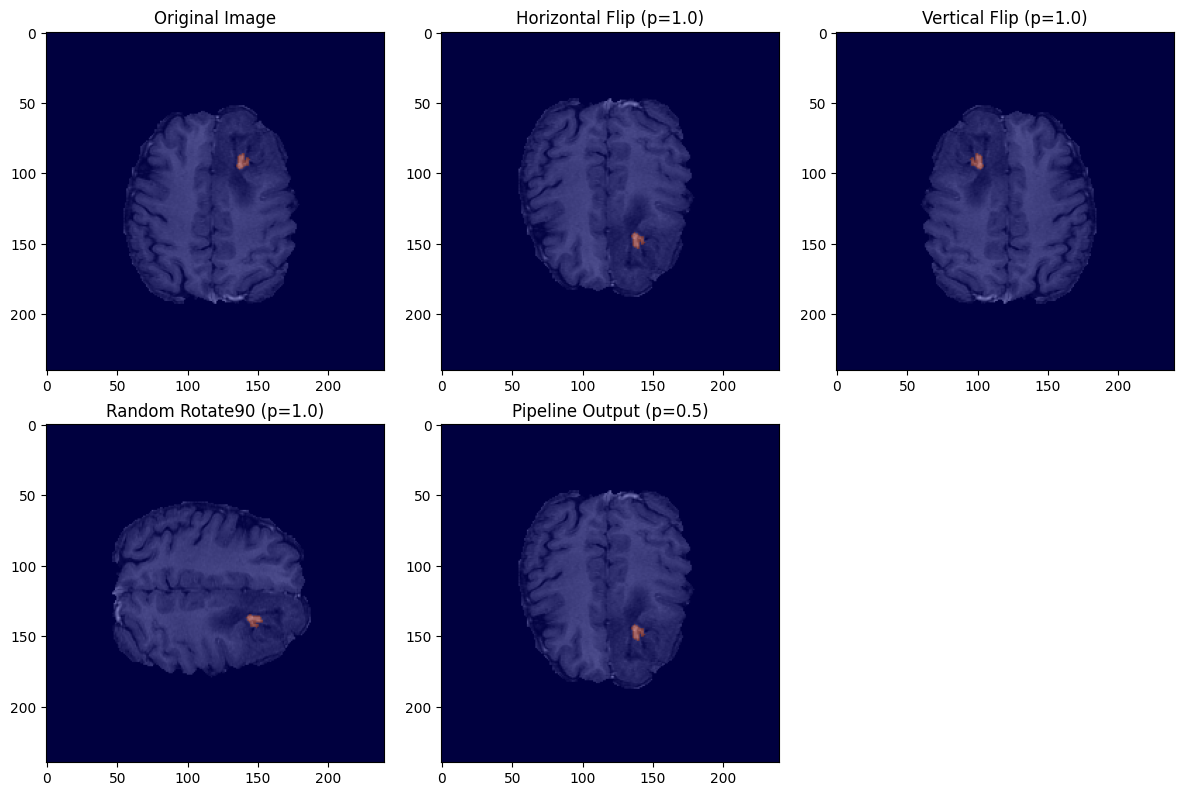

In [ ]:
# Visualize data augmentation

## Load an a slice from a patient as an example :
example = "patient_001_0100.nii.gz"
path_image, path_mask = f"data/train/images/{example}", f"data/train/masks/{example}"
image_nii, mask_nii = nib.load(path_image), nib.load(path_mask)
image = image_nii.get_fdata().astype(np.float32)
mask = mask_nii.get_fdata().astype(np.float32)


# Define individual transformations with probability p=1.0 for visualization purposes
# This ensures that the transformations are always applied for demonstration
hflip = A.HorizontalFlip(p=1.0)     # Horizontal flip transformation
vflip = A.VerticalFlip(p=1.0)       # Vertical flip transformation
rotate90 = A.RandomRotate90(p=1.0)  # Random 90-degree rotation transformation

# Define the training augmentation pipeline
# This pipeline combines multiple transformations with specified probabilities
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5)
])

# Apply each transformation individually to the example image and mask
hflip_aug = hflip(image=image, mask=mask)
img_hflip, mask_hflip = hflip_aug["image"], hflip_aug["mask"]

vflip_aug = ...
img_vflip, mask_vflip = ...

rotate90_aug = ...
img_rotate90, mask_rotate90 = ...

# Apply the composed pipeline (output will vary because of randomness)
pipeline_aug = ...
img_pipeline, mask_pipeline = ...

# Visualize the results with overlayed masks
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

axes[0].imshow(image.T, cmap="gray")
axes[0].imshow(mask.T, cmap="jet", alpha=0.5)
axes[0].set_title("Original Image")

axes[1].imshow(img_hflip.T, cmap="gray")
axes[1].imshow(mask_hflip.T, cmap="jet", alpha=0.5)
axes[1].set_title("Horizontal Flip (p=1.0)")

axes[2].imshow(img_vflip.T, cmap="gray")
axes[2].imshow(mask_vflip.T, cmap="jet", alpha=0.5)
axes[2].set_title("Vertical Flip (p=1.0)")

axes[3].imshow(img_rotate90.T, cmap="gray")
axes[3].imshow(mask_rotate90.T, cmap="jet", alpha=0.5)
axes[3].set_title("Random Rotate90 (p=1.0)")

axes[4].imshow(img_pipeline.T, cmap="gray")
axes[4].imshow(mask_pipeline.T, cmap="jet", alpha=0.5)
axes[4].set_title("Pipeline Output (p=0.5)")

# Hide the unused subplot
axes[5].axis("off")

plt.tight_layout()
plt.show()


## 🧠 Exercise 7:  Create Train and Validation datasets and dataloaders

In this exercise, you will create custom **Dataset** and **DataLoader** objects for the training and validation datasets, incorporating the **data augmentation pipeline** you defined earlier. This is an essential step in preparing your data for training a deep learning model.


In [ ]:
# Path to the training data directory
dir_train = ...

# Create a BratsDataset object for the training set
train_dataset = BratsDataset(
    dir_data = ...,
    list_slices=...,
    transform=...
)

# Create a BratsDataset object for the validation set
# Use the validation slice filenames and do not apply any augmentations
val_dataset = BratsDataset(
    dir_data = ...,
    list_slices=...,
    transform=...
)


In [ ]:
# Create DataLoader objects for the training and validation datasets
# We'll use a batch size of 64 for both dataloaders
train_dataloader = DataLoader(
    train_dataset,  # Training dataset
    batch_size=64,  # Number of samples per batch
    shuffle=True,  # Shuffle the data at the beginning of each epoch
    num_workers=2  # Number of worker processes for data loading (adjust based on your system)
)

val_dataloader = DataLoader(
    ...,  # Validation dataset
    batch_size=...,  # Number of samples per batch
    shuffle=False,  # Do not shuffle the validation data
    num_workers=2  # Number of worker processes for data loading (adjust based on your system)
)


## 🧠 Exercise 8:  Train the model

Train the model for one loop by completing the training loop's code :

In [ ]:
import tqdm as tqdm

# Set the number of training epochs
num_epochs = 1

# Initialize lists to store training and validation loss history
train_loss_history = []
val_loss_history = []

# Initialize the best validation loss to a very large value (infinity)
# This will be updated during training when a lower validation loss is achieved
best_val_loss = float('inf')

# Iterate over the specified number of epochs
for epoch in range(num_epochs):
    # --------------------------
    # Training Phase
    # --------------------------
    # Set the model to training mode
    # This enables certain layers like dropout and batch normalization that are only used during training
    model.train()
    # Initialize a list to store training losses for the current epoch
    train_losses = []

    # Create a progress bar using tqdm to track the training progress
    with tqdm.tqdm(total=len(train_dataloader), desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch") as pbar:
        # Iterate over the training data in batches
        for batch in train_dataloader:
            # Move the input images and target masks to the appropriate device (GPU if available)
            inputs, labels = ....to(device), ....to(device)

            # Zero the gradients of the optimizer
            # This is necessary before each backpropagation step to avoid accumulating gradients from previous iterations
            optimizer.zero_grad()

            # Forward pass: Get the model's predictions for the input images
            outputs = ...

            # Compute the loss between the model's predictions and the target masks
            loss = ...

            # Backward pass: Calculate the gradients of the loss with respect to the model's parameters
            loss.backward()
            # Update the model's parameters based on the calculated gradients
            optimizer.step()

            # Save the loss for the current batch and update the progress bar
            train_losses.append(loss.item())  # Append the loss value to the list
            pbar.update(1)
            pbar.set_postfix({"training_loss": loss.item()})

    # Compute the average training loss for the epoch
    avg_train_loss = sum(train_losses) / len(train_losses)
    # Add the average training loss to the loss history
    train_loss_history.append(avg_train_loss)

    # --------------------------
    # Validation Phase
    # --------------------------
    print("Validation in progress ...")  # Print a message indicating the start of validation
    # Set the model to evaluation mode
    # This disables certain layers like dropout and batch normalization that are only used during training
    model.eval()
    # Initialize a list to store validation losses for the current epoch
    val_losses = []

    # Disable gradient computation during validation to save memory and speed up computation
    with torch.no_grad():
        # Create a progress bar using tqdm to track the validation progress
        with tqdm.tqdm(total=len(val_dataloader), desc=f"Validation Epoch {epoch + 1}/{num_epochs}", unit="batch") as pbar_val:
            # Iterate over the validation data in batches
            for batch in val_dataloader:
                # Move the input images and target masks to the appropriate device (GPU if available)
                inputs, labels = ...

                # Forward pass: Get the model's predictions for the input images
                outputs = ...

                # Compute the loss between the model's predictions and the target masks
                loss = ...

                # Save the loss for the current batch and update the progress bar
                val_losses.append(loss.item())  # Append the loss value to the list
                pbar_val.update(1)
                pbar_val.set_postfix({"validation_loss": loss.item()})

    # Compute the average validation loss for the epoch
    avg_val_loss = sum(val_losses) / len(val_losses)
    # Add the average validation loss to the loss history
    val_loss_history.append(avg_val_loss)

    print(f"Epoch {epoch + 1}/{num_epochs} - Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    # --------------------------
    # Save Model Checkpoints
    # --------------------------
    # Save the model's state dictionary after each epoch (last model)
    torch.save(model.state_dict(), "last_model.pth")

    # If the current validation loss is the best so far, save the model as the best model
    if ... < ...:
        best_val_loss = ...  # Update the best validation loss
        torch.save(model.state_dict(), "best_model.pth")  # Save the model's state dictionary
        print(f"Best model updated at epoch {epoch + 1} with validation loss {avg_val_loss:.4f}")


Epoch 1/1: 100%|██████████| 500/500 [09:44<00:00,  1.17s/batch, training_loss=0.0127]


Validation in progress ...


Validation Epoch 1/1: 100%|██████████| 126/126 [00:46<00:00,  2.70batch/s, validation_loss=0.0104]


Epoch 1/1 - Training Loss: 0.0816, Validation Loss: 0.0117
Best model updated at epoch 1 with validation loss 0.0117


## 🧠 Exercise 9:  Evaluate the one-epoch trained model


To evaluate our model, we will use the **Dice Score**.

The Dice score, is a statistical metric used to gauge the similarity between two sets. In the context of image segmentation, we use it to assess how well the predicted segmentation mask overlaps with the ground truth mask.


Imagine you have two shapes, one representing the ground truth segmentation (where the tumor actually is) and the other representing the model's prediction. The Dice score essentially measures how much these two shapes overlap, relative to their total combined area.

<div style="text-align: center;">
    <img src="https://raw.githubusercontent.com/maichi98/PythonM2-jour4/main/resources/dice.png" alt="Classification vs Detection vs Segmentation" width="800px">
</div>

In this exercise, we will first create the custom test dataset and loader,  then we will evaluate the predictions of our one-epoch trained model, by computing the **dice** per slice, then we will compute the dice per **Test patient** :


In [ ]:
# Create the test dataset and dataloader

# path to the test data directory
dir_test = ...

# Create a BratsDataset object for the test set
# Use the test slice filenames and do not apply any augmentations
test_dataset = BratsDataset(
    dir_data=...,  # Path to the test data
    list_slices=...,  # List of test slice filenames
    transform=...  # No augmentations for the test set
)

# Create a DataLoader for the test dataset
# Use a batch size of 1 and do not shuffle the data
test_dataloader = DataLoader(
    test_dataset,  # Test dataset
    batch_size=1,  # Batch size of 1 (process one slice at a time)
    shuffle=False  # Do not shuffle the test data
)


In [ ]:
import pandas as pd

# Set a smoothing parameter (epsilon) to avoid division by zero when calculating the Dice score
eps = 1e-6

# Set the model in evaluation mode :
...

# Create a pandas DataFrame to store the results for each slice
df_dice = pd.DataFrame(columns=["slice_name", "patient", "slice", "union", "intersection", "dice"])


# Disable gradient calculation during inference
with torch.no_grad():
    for batch in test_dataloader:

        # Get the slice name from the batch data
        slice_name = batch["slice_name"][0]

        # Move input images and target masks to the device
        inputs, labels = batch["image"].to(device), batch["mask"].to(device)

        # Forward pass
        outputs = model(inputs)
        # Squeeze out the channel dimension: now (B, H, W)
        outputs = outputs.squeeze(1)
        labels = labels.squeeze(1)

        # Apply sigmoid activation to convert the model's raw outputs (logits) to probabilities
        outputs = torch.sigmoid(outputs)
        # Threshold the probabilities to obtain binary predictions (0 or 1)
        # A threshold of 0.5 is commonly used for binary segmentation
        outputs = (outputs > 0.5).float()
        labels = labels.float()

        # Calculate the intersection and union of the predicted and ground truth masks
        intersection = (outputs * labels).sum(dim=(1, 2))
        union = outputs.sum(dim=(1, 2)) + labels.sum(dim=(1, 2))

        intersection, union = intersection.item(), union.item()

        # Compute Dice coefficient for this batch (or single sample, if batch_size==1)
        dice = (((2.0 * intersection) + eps) / (union + eps))

        print(fr"Slice name : {slice_name} -- GT volume: {labels.sum().item()}mm^3 -- Dice score: {dice * 100:.2f} %")
        df_dice.loc[len(df_dice)] = {
            "slice_name": slice_name, "patient": slice_name.split("_")[1], "slice": slice_name.split("_")[2],
            "union": union, "intersection": intersection, "dice": dice
        }


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Slice name : patient_140_0122 -- GT volume: 0.0mm^3 -- Dice score: 100.00 %
Slice name : patient_331_0061 -- GT volume: 0.0mm^3 -- Dice score: 100.00 %
Slice name : patient_239_0125 -- GT volume: 0.0mm^3 -- Dice score: 100.00 %
Slice name : patient_073_0054 -- GT volume: 0.0mm^3 -- Dice score: 100.00 %
Slice name : patient_064_0085 -- GT volume: 814.0mm^3 -- Dice score: 57.76 %
Slice name : patient_064_0040 -- GT volume: 443.0mm^3 -- Dice score: 63.05 %
Slice name : patient_076_0103 -- GT volume: 0.0mm^3 -- Dice score: 100.00 %
Slice name : patient_074_0073 -- GT volume: 0.0mm^3 -- Dice score: 100.00 %
Slice name : patient_325_0053 -- GT volume: 600.0mm^3 -- Dice score: 78.07 %
Slice name : patient_074_0048 -- GT volume: 0.0mm^3 -- Dice score: 100.00 %
Slice name : patient_140_0065 -- GT volume: 0.0mm^3 -- Dice score: 100.00 %
Slice name : patient_199_0056 -- GT volume: 0.0mm^3 -- Dice score: 100.00 %
Slice n

In [ ]:
# Compute the average Dice score across all test slices :
average_dice = ...
print(f"Average Dice score across all test slices: {average_dice * 100:.2f}%")


Average Dice score across all test slices: 79.88%


In [ ]:
# Group the DataFrame by patient
patient_dice = df_dice.groupby("patient")

# Calculate the sum of intersections and unions for each patient
patient_stats = patient_dice.agg({"intersection": "sum",
                                  "union": "sum"})

# Calculate the Dice score for each patient
patient_stats["dice"] = ...

# Print the Dice score for each patient
print("Dice scores per patient:")
print(patient_stats[["dice"]].map(lambda x: f"{x * 100:.2f}%"))

# Calculate the average Dice score across all patients
average_patient_dice = patient_stats["dice"].mean()
print(f"\nAverage Dice score across all patients: {average_patient_dice * 100:.2f}%")


Dice scores per patient:
            dice
patient         
004       72.24%
006       89.50%
010       65.57%
026       25.50%
034       55.51%
043       84.12%
046        9.95%
047       26.81%
058       16.99%
064       46.70%
073       51.63%
074       52.04%
076       42.71%
077        0.00%
078       86.57%
095        0.00%
102       68.86%
110        0.00%
112      100.00%
115        0.00%
125       78.16%
140      100.00%
141       90.71%
144        0.00%
148       87.42%
173        0.00%
174       31.04%
180       32.77%
182       64.90%
183       49.10%
184       82.53%
186        0.00%
197      100.00%
199        0.00%
203       54.96%
220       80.90%
226        0.00%
229        0.00%
239       13.26%
256       28.18%
272        9.89%
275        0.44%
283       26.51%
303        0.00%
311       72.23%
315       52.63%
317        0.00%
319       42.32%
325       76.63%
326       71.22%
331        8.76%

Average Dice score across all patients: 42.14%


## 🧠 Exercise 10:  Evaluate a fully-trained model


In this exercise, we will load a pre-trained model and evaluate the predictions of our one-epoch trained model, by computing the **dice** per slice, then we will compute the dice per **Test patient** :

In [ ]:
# Load the trained model

# Determine the device to use for inference (GPU if available, otherwise CPU)
device = ...

# Create an instance of the U-Net model
fully_trained_model = ...
# Load the model's state dictionary from the saved file
# 'best_model_12022025.pth' is the filename of the saved model
fully_trained_model.load_state_dict(torch.load(..., map_location=device))

# Move the model to the selected device (GPU or CPU)
...


<ipython-input-22-45187d30bc5b>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fully_trained_model.load_state_dict(torch.load("best_model_12022025.pth", map_location=devi

UNet(
  (enc1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running

In [ ]:
fully_trained_model.eval()

# Create a pandas DataFrame to store the results for each slice
df_fully_trained_dice = pd.DataFrame(columns=["slice_name", "patient", "slice", "union", "intersection", "dice"])


# Disable gradient calculation during inference
with torch.no_grad():
    for batch in test_dataloader:

        # Get the slice name from the batch data
        slice_name = batch["slice_name"][0]

        # Move input images and target masks to the device
        inputs, labels = batch["image"].to(device), batch["mask"].to(device)

        # Forward pass
        outputs = fully_trained_model(inputs)
        # Squeeze out the channel dimension: now (B, H, W)
        outputs = outputs.squeeze(1)
        labels = labels.squeeze(1)

        # Apply sigmoid activation to convert the model's raw outputs (logits) to probabilities
        outputs = torch.sigmoid(outputs)
        # Threshold the probabilities to obtain binary predictions (0 or 1)
        # A threshold of 0.5 is commonly used for binary segmentation
        outputs = (outputs > 0.5).float()
        labels = labels.float()

        # Calculate the intersection and union of the predicted and ground truth masks
        intersection = (outputs * labels).sum(dim=(1, 2))
        union = outputs.sum(dim=(1, 2)) + labels.sum(dim=(1, 2))

        intersection, union = intersection.item(), union.item()

        # Compute Dice coefficient for this batch (or single sample, if batch_size==1)
        dice = (((2.0 * intersection) + eps) / (union + eps))

        print(fr"Slice name : {slice_name} -- GT volume: {labels.sum().item()}mm^3 -- Dice score: {dice * 100:.2f} %")
        df_fully_trained_dice.loc[len(df_fully_trained_dice)] = {
            "slice_name": slice_name, "patient": slice_name.split("_")[1], "slice": slice_name.split("_")[2],
            "union": union, "intersection": intersection, "dice": dice
        }


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Slice name : patient_140_0122 -- GT volume: 0.0mm^3 -- Dice score: 100.00 %
Slice name : patient_331_0061 -- GT volume: 0.0mm^3 -- Dice score: 100.00 %
Slice name : patient_239_0125 -- GT volume: 0.0mm^3 -- Dice score: 100.00 %
Slice name : patient_073_0054 -- GT volume: 0.0mm^3 -- Dice score: 100.00 %
Slice name : patient_064_0085 -- GT volume: 814.0mm^3 -- Dice score: 77.89 %
Slice name : patient_064_0040 -- GT volume: 443.0mm^3 -- Dice score: 84.20 %
Slice name : patient_076_0103 -- GT volume: 0.0mm^3 -- Dice score: 100.00 %
Slice name : patient_074_0073 -- GT volume: 0.0mm^3 -- Dice score: 0.00 %
Slice name : patient_325_0053 -- GT volume: 600.0mm^3 -- Dice score: 90.68 %
Slice name : patient_074_0048 -- GT volume: 0.0mm^3 -- Dice score: 100.00 %
Slice name : patient_140_0065 -- GT volume: 0.0mm^3 -- Dice score: 100.00 %
Slice name : patient_199_0056 -- GT volume: 0.0mm^3 -- Dice score: 100.00 %
Slice nam

In [ ]:
# Compute the average Dice score across all test slices :
average_dice = df_fully_trained_dice["dice"].mean()
print(f"Average Dice score across all test slices: {average_dice * 100:.2f}%")


Average Dice score across all test slices: 87.06%


In [ ]:
# Group the DataFrame by patient
patient_dice = df_fully_trained_dice.groupby("patient")

# Calculate the sum of intersections and unions for each patient
patient_stats = patient_dice.agg({"intersection": "sum",
                                  "union": "sum"})

# Calculate the Dice score for each patient
patient_stats["dice"] = ((2 * patient_stats["intersection"]) + eps) / (patient_stats["union"] + eps)

# Print the Dice score for each patient
print("Dice scores per patient:")
print(patient_stats[["dice"]].map(lambda x: f"{x * 100:.2f}%"))

# Calculate the average Dice score across all patients
average_patient_dice = patient_stats["dice"].mean()
print(f"\nAverage Dice score across all patients: {average_patient_dice * 100:.2f}%")


Dice scores per patient:
            dice
patient         
004       87.66%
006       90.86%
010       76.11%
026       85.44%
034       91.91%
043       85.17%
046       67.66%
047       82.22%
058       72.49%
064       69.36%
073       82.86%
074       88.95%
076       87.84%
077        0.00%
078       93.85%
095       62.81%
102       76.67%
110       59.74%
112      100.00%
115       26.99%
125       89.65%
140      100.00%
141       94.95%
144       45.30%
148       91.91%
173       81.43%
174       85.67%
180       86.72%
182       86.27%
183       87.86%
184       92.99%
186        0.00%
197        0.00%
199        0.00%
203       82.55%
220       88.08%
226       22.22%
229        0.00%
239       81.00%
256       46.79%
272       51.69%
275        4.01%
283       80.93%
303       77.14%
311       90.66%
315       90.84%
317       25.09%
319       89.67%
325       91.73%
326       90.27%
331       82.78%

Average Dice score across all patients: 69.15%


## 🧠 Exercise 11:  prediction plots

In this exercise, let's plot some predictions from a patient with a high dice and from a patient with low dice 🇰


In [ ]:
import random

random.seed(42)

def plot_slices(patient, n_slices, model, df_dice):
    list_patient_slices = [s for s in list_test_slices if patient in s]

    n_slices = min(n_slices, len(list_patient_slices))

    # Randomly choose n_slices without picking the same slice twice.
    list_patient_slices = random.sample(list_patient_slices, n_slices)

    _test_dataset = BratsDataset(
        dir_data=dir_test,
        list_slices=list_patient_slices,
        transform=None
    )

    _test_dataloader = DataLoader(_test_dataset, batch_size=1, shuffle=False)

    model.eval()

    root = int(np.sqrt(n_slices)) + 1

    # Create a figure and a grid of subplots
    fig = plt.figure(figsize=(5 * root, 5 * root))

    for i, batch in enumerate(_test_dataloader):
        slice_name = batch["slice_name"][0]
        inputs, labels = batch["image"].to(device), batch["mask"].to(device)

        outputs = model(inputs)
        outputs = outputs.squeeze(1)
        labels = labels.squeeze(1)

        outputs = torch.sigmoid(outputs)
        outputs = (outputs > 0.5).float()
        labels = labels.float()

        dice = df_dice[df_dice["slice_name"] == slice_name]["dice"].values[0]

        # Plot on the correct subplot
        ax = fig.add_subplot(root, root, i + 1)

        ax.imshow(inputs[0, 0, :, :].cpu().numpy().T, cmap="gray")

        # Display only labels with value 1 (tumor region)
        masked_labels = np.ma.masked_where(labels[0, :, :].cpu().numpy().T == 0, labels[0, :, :].cpu().numpy().T)
        ax.imshow(masked_labels, cmap="Blues", alpha=1)

        masked_outputs = np.ma.masked_where(outputs[0, :, :].cpu().numpy().T == 0, outputs[0, :, :].cpu().numpy().T)
        ax.imshow(masked_outputs, cmap="jet", alpha=0.4)

        ax.set_title(f"{slice_name} - Dice: {dice:.2f}", fontsize=14)
        ax.axis("off")
        ax.axis("off")  # Turn off axis ticks and labels

    plt.tight_layout()  # Adjust subplot spacing
    plt.show()  # Display the figure



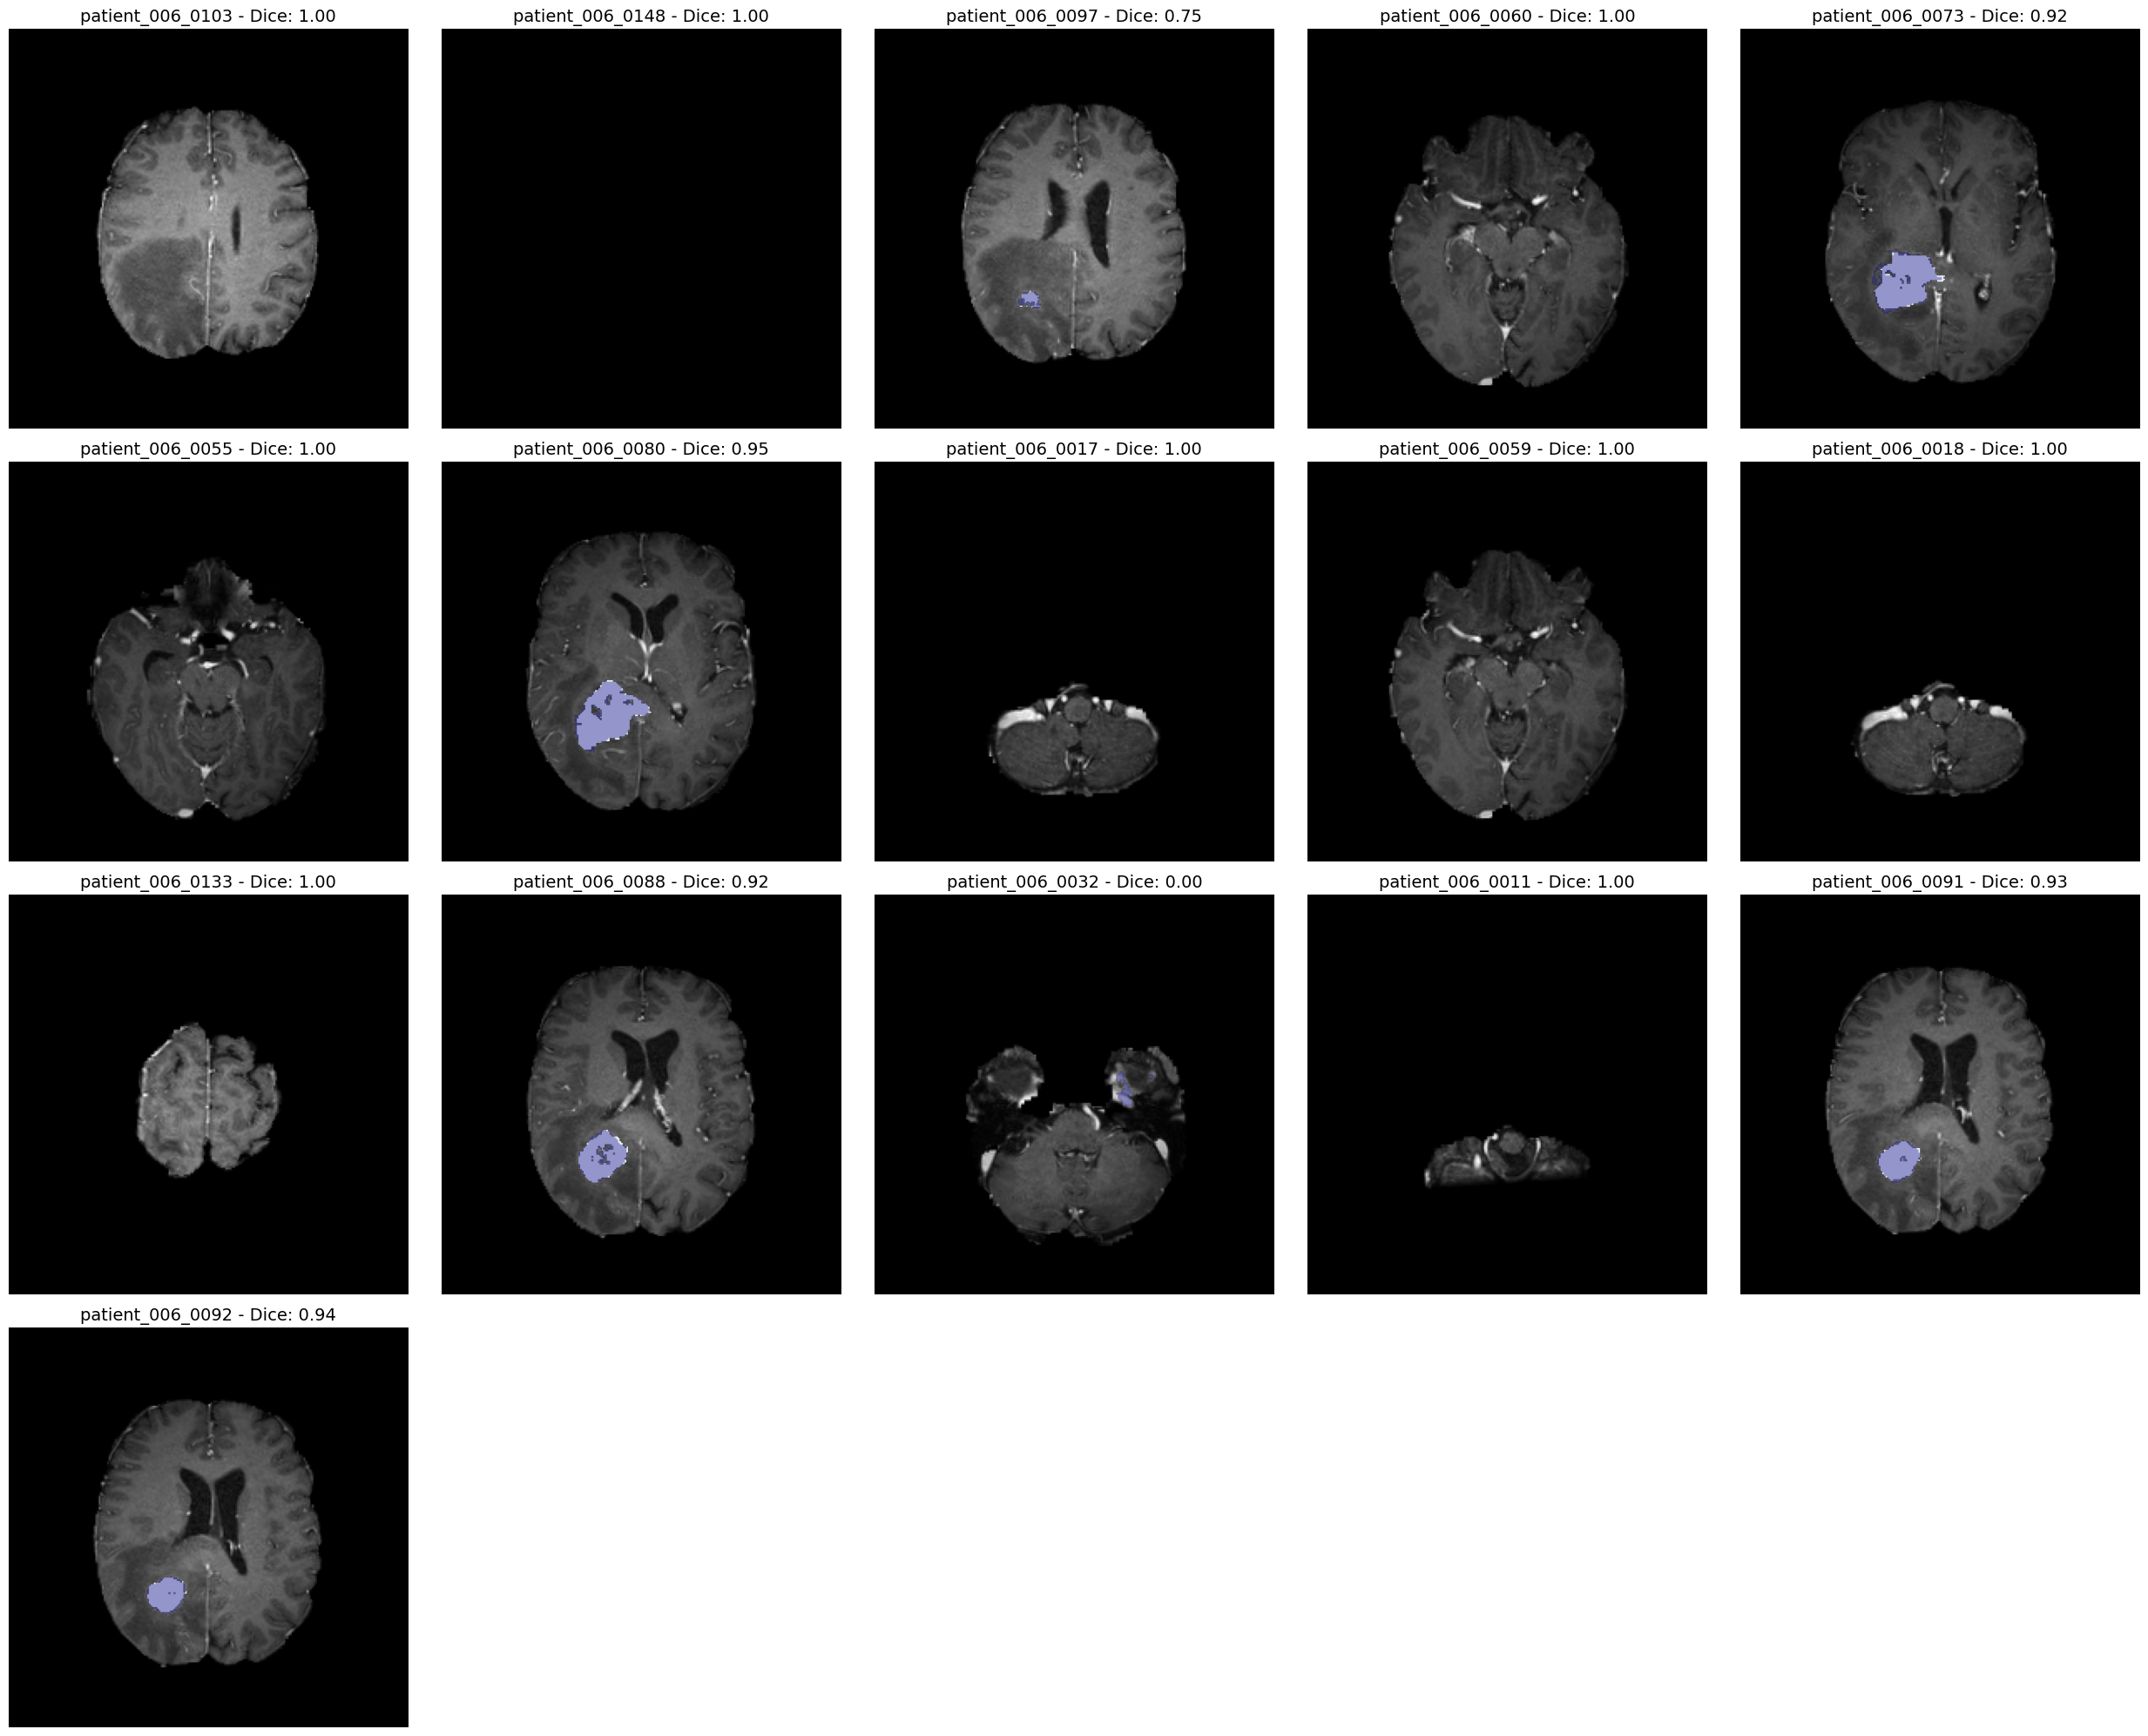

In [ ]:
high_dice_patient = "patient_006"

plot_slices(high_dice_patient, 16, fully_trained_model, df_fully_trained_dice)

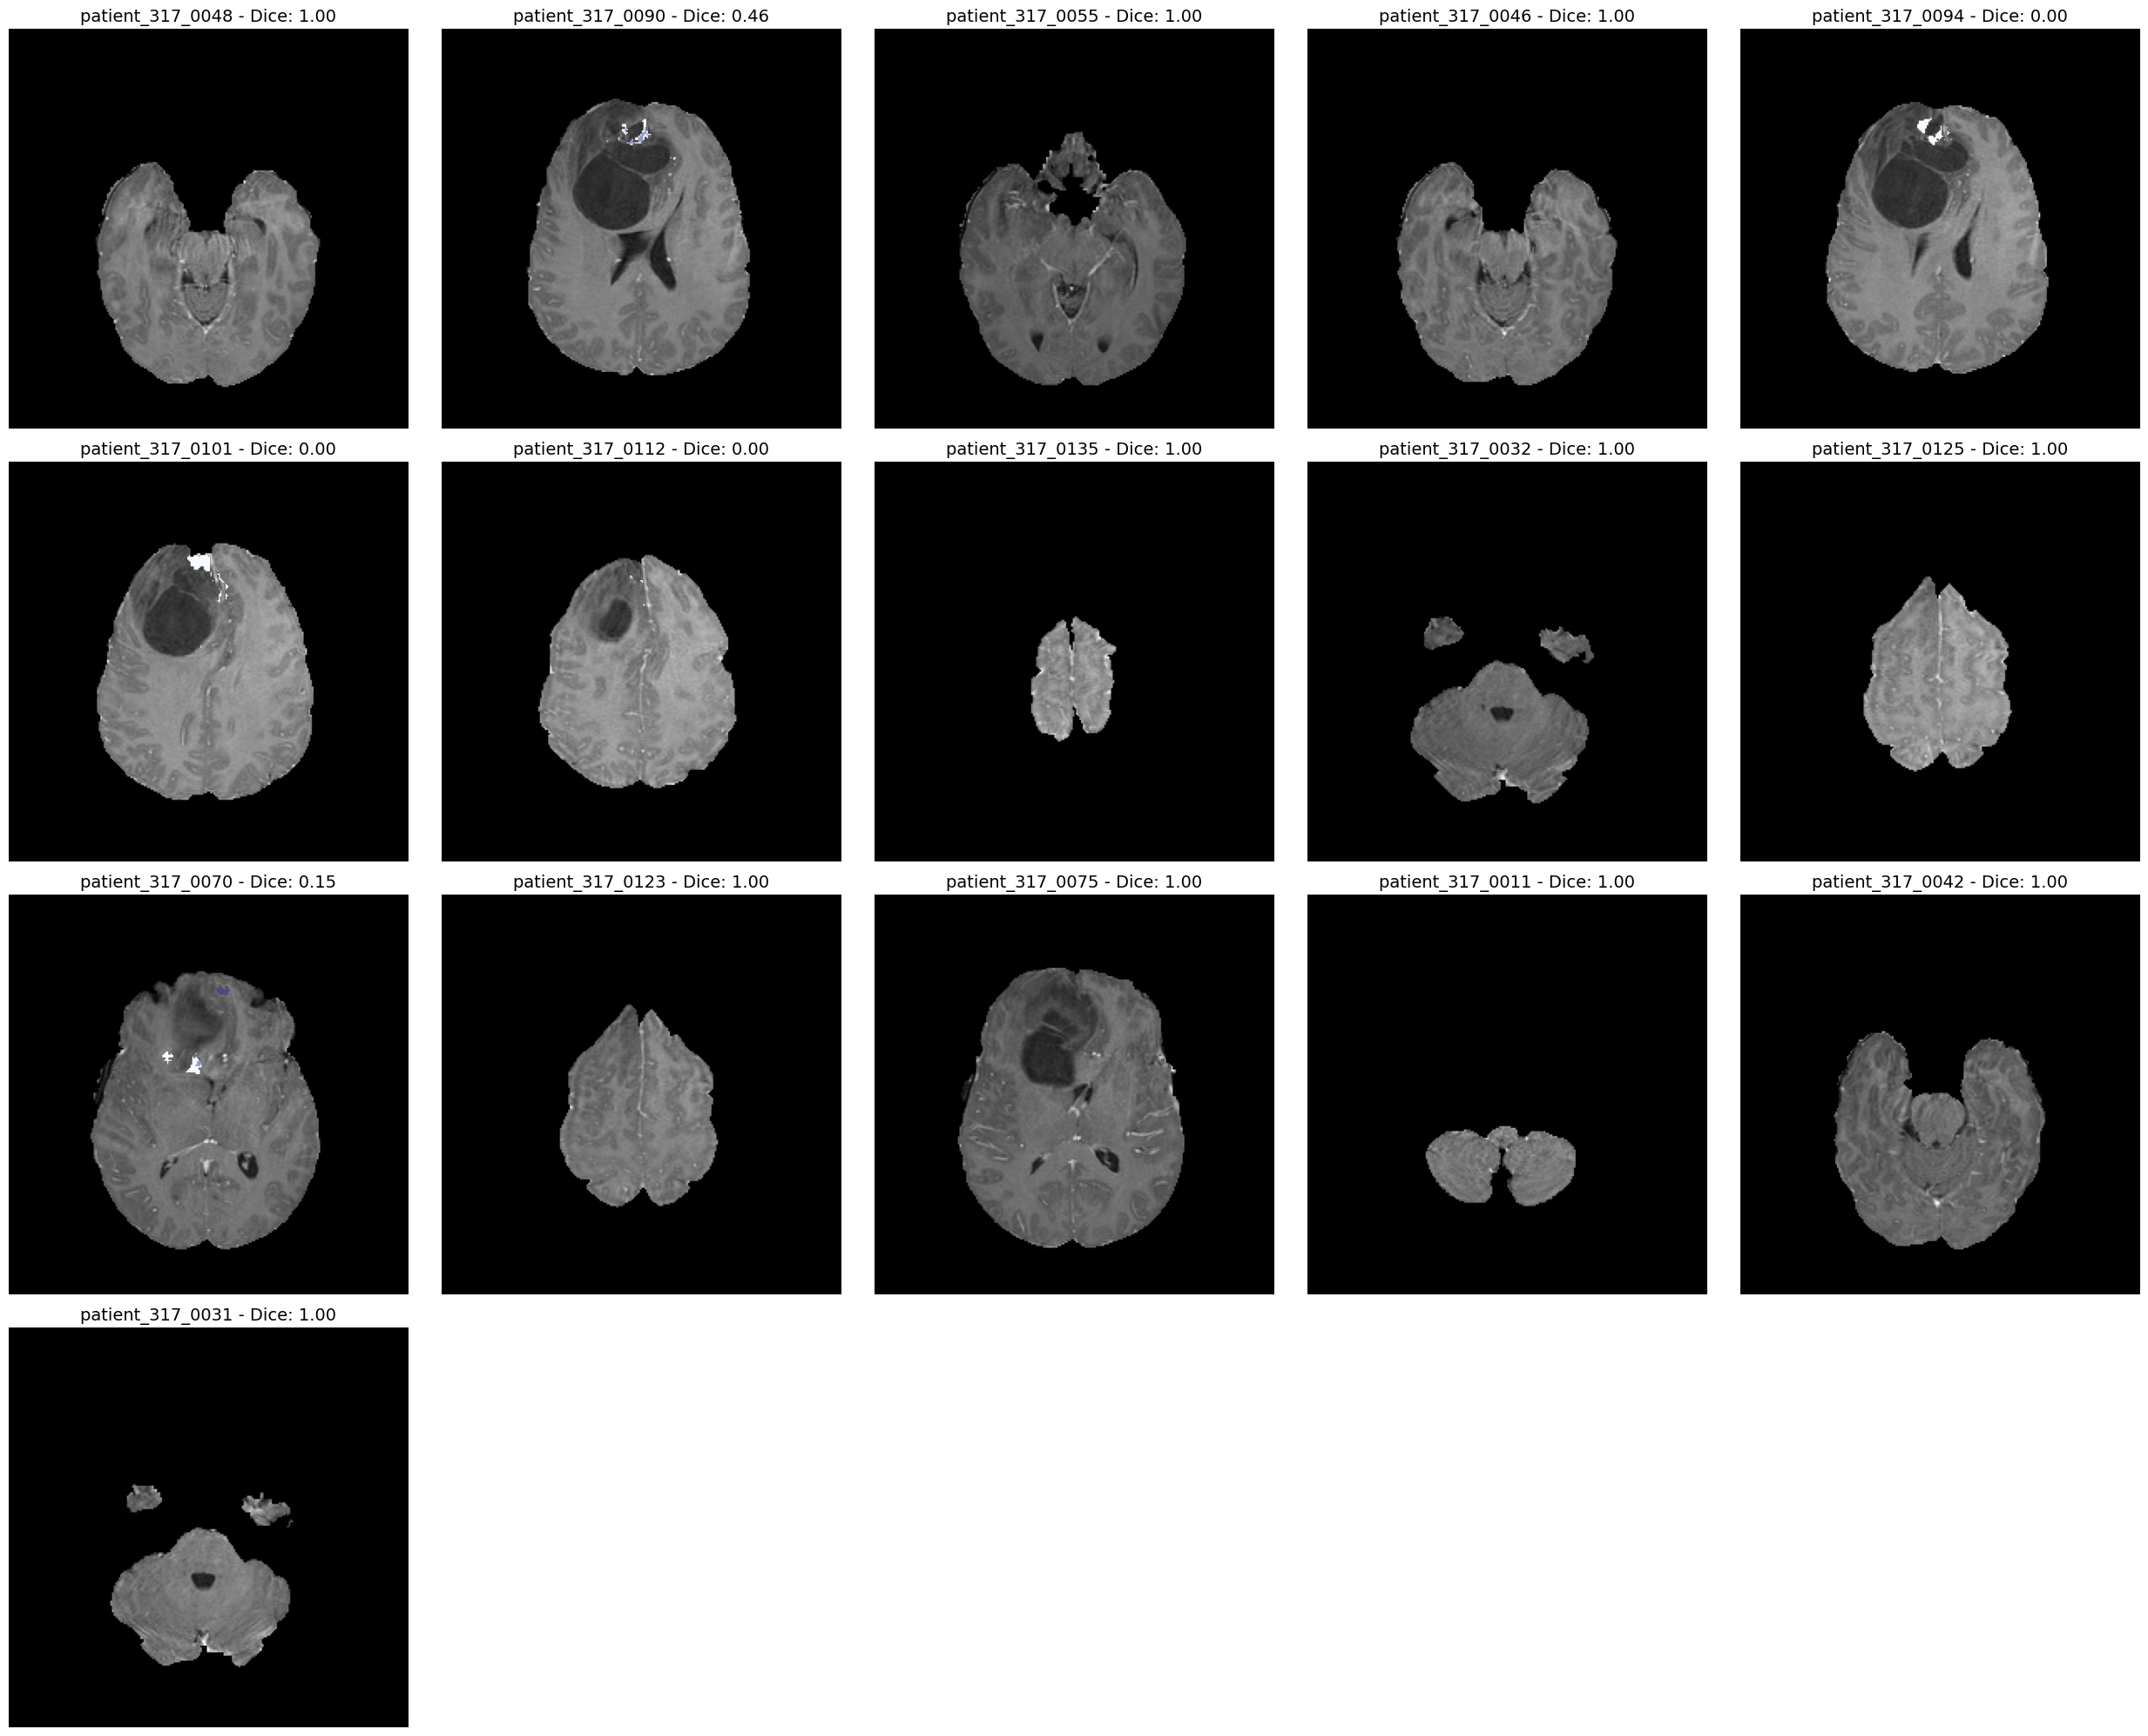

In [ ]:
low_dice_patient = "patient_317"

plot_slices(low_dice_patient, 16, fully_trained_model, df_fully_trained_dice)

